# Link Analysis
Conducting a link analysis of a network graph involves identifying and analyzing the link within the graph. 

In [1]:
import pandas as pd
import numpy as np
import networkx as nx 

import matplotlib.pyplot as plt
from ast import literal_eval

from os.path import join
import os

# from token_projection.token_projection import *
# from utilities.metrics_and_tests import * 
# from utilities.utils import * 

from dotenv import load_dotenv
load_dotenv()  

path = os.environ['DATA_DIRECTORY']
covalent_key = os.environ['COVALENTHQ_API_KEY']
df_snapshots = pd.read_csv('../data/snapshot_selection.csv')
df_tokens = pd.read_csv("../data/final_token_selection.csv")
# df_tokens = pd.read_csv('../assets/df_final_token_selection_20230813.csv')

# remove burner addresses 
known_burner_addresses = ['0x0000000000000000000000000000000000000000',
                        '0x0000000000000000000000000000000000000000',
                        '0x0000000000000000000000000000000000000001',
                        '0x0000000000000000000000000000000000000002',
                        '0x0000000000000000000000000000000000000003',
                        '0x0000000000000000000000000000000000000004',
                        '0x0000000000000000000000000000000000000005',
                        '0x0000000000000000000000000000000000000006',
                        '0x0000000000000000000000000000000000000007',
                        '0x000000000000000000000000000000000000dead']


/home/user/eisermann/.local/lib/python3.9/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.2' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/user/eisermann/.local/lib/python3.9/site-packages/pandas/core/arrays/masked.py:59: UserWarning: Pandas requires version '1.3.2' or newer of 'bottleneck' (version '1.2.1' currently installed).
  from pandas.core import (


In [2]:
import sys
sys.path.append('..') 

from src.analysis.clique_analysis import * 
from src.utilities.metrics_and_tests import jaccard_similarity, pval_to_significance
from src.utilities.utils import *

## Create dataframes for each metrics

In [5]:
import pickle

# Specify the path to the file containing the saved cliques data
links_data_path = join(path, 'data/links_data.pkl')

# Load the cliques dictionary from the file
with open(links_data_path, 'rb') as handle:
    links = pickle.load(handle)



In [ ]:
# cliques

In [6]:
links['sample']['2021-02-15']["""['YFI', 'AAVE']"""]

{'size_link': 256,
 'total_influence': 0.09050230902641497,
 'gini_total_influence': 0.9151777804596927,
 'internal_influence': 0.24452097455823127,
 'gini_internal_influence': 0.9352256593161816,
 'external_influence': 0.05199764264346089,
 'gini_external_influence': 0.8863114321695255,
 'wealth_link': 4169404707.1049547,
 'gini_wealth_link': 0.9266192776642748,
 'median_wealth_level_link': 360686.8617837437,
 'median_no_assets_link': 3.0,
 'max_influence_label': ('IEMOA', 0.05995391474247112),
 'max_influence_label_distribution': {'IEMOA': 0.05995391474247112,
  'PCV': 0.00028387897577904724,
  'bridge_contract': 0.0014097009007201732,
  'lending_borrowing_contract': 0.014259007679928107,
  'other_contracts': 0.014595806727516522}}

In [7]:
# Define the list of metric names
metric_names = list(links['sample']['2021-02-15']["""['YFI', 'AAVE']"""].keys())

# Initialize an empty dictionary to store DataFrames for each metric
# metric_dataframes = {'sample': {},'control': {}}

# metric_dataframes = {
#             'upper_bound': {'sample': {},'control': {}}, 
#             'lower_bound': {'sample': {},'control': {}}       
#             }

metric_dataframes = {'sample': {},'control': {},'pvalues': {}}     


# Define a function to create a DataFrame for a given metric
def create_metric_dataframe(metric_name, key2):
    data = []

    # Iterate through cliques and snapshots to collect data for the metric
    for date, snapshot_data in links[key2].items():
        for link_name, metrics in snapshot_data.items():
            
            try:
                data.append({
                'Date': date,
                'Link Name': link_name,
                metric_name: metrics[metric_name]
            })
            
            except:
                data.append({
                'Date': date,
                'Link Name': link_name,
                metric_name: np.nan
            })
            
            
            

    # Create a DataFrame for the metric
    df_metric = pd.DataFrame(data)
    
    # Pivot the DataFrame to have snapshots as columns and clique names as rows
    df_metric = df_metric.pivot(index='Link Name', columns='Date', values=metric_name)

    # Store the DataFrame in the dictionary with a key representing the metric
    metric_dataframes[key2][metric_name] = df_metric

# Call the function for each metric in the list


    
for group in ['sample', 'control', 'pvalues']:

    for metric_name in metric_names:

        create_metric_dataframe(metric_name, group)



## Figure Generation

In [8]:
FONT_SIZE_LABEL = 18
FONT_SIZE_TICK = 16
FONT_SIZE_TITLE = 24
LINE_SPACING=1.5
FONT_SIZE_VALUE = 12
FIG_SIZE = (18, 15)
COLORS = ['white', 'black']
COLORMAP = 'CMRmap'

### Fig: Size of Clique 

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from os.path import join

def plot_link_size_over_time(metric_dataframes, group='sample', output_path="output/links/", save=True, show=True):
    
    # Define df 
    df = metric_dataframes[group]['size_link']
    df_influenece = metric_dataframes[group]['total_influence']

    
    # common index
    df_index = metric_dataframes['sample']['size_link']

    # Find the index of the first occurrence (value > 1) in each column (snapshot)
    first_occurrence_indices = (df_index.T > 1).idxmax()

    # Determine the minimum index (earliest occurrence) for each link across all snapshots
    min_indices = first_occurrence_indices.groupby(first_occurrence_indices.index).min()

    # Sort the links based on their minimum indices to get the desired order
    links_order = min_indices.sort_values().index.tolist()

    # Reindex link size to df_presence 
    df = df.reindex(links_order)

    # Create a mask for cells where 'link_size' is greater than 1
    mask = df.values >= 1

    # Create a custom colormap with gray for values > 1 and white for values <= 1
    cmap = mcolors.ListedColormap(COLORS)

    # Create the binary chart with custom coloring
    fig, ax = plt.subplots(figsize=FIG_SIZE)
    im = ax.imshow(mask, cmap=cmap, aspect='auto', interpolation='none')

    # Set ticks and labels
    ax.set_xticks(np.arange(len(df.columns)))
    ax.set_yticks(np.arange(len(df.index)))
    ax.set_xticklabels(df.columns, rotation='vertical')
    ax.set_yticklabels(df.index, fontsize=FONT_SIZE_TICK, va='center', linespacing=LINE_SPACING)

    # Annotate the chart with 'link_size' values, skipping 'NaN' values
    for i in range(len(df.index)):
        for j in range(len(df.columns)):
            value = df.values[i, j]
            if not np.isnan(value):
                text = ax.text(j, i, (str(round(value))), ha='center', va='center', color='white', fontsize=FONT_SIZE_VALUE)

    # Set labels and title
    plt.xlabel('Timestamps', fontsize=FONT_SIZE_LABEL)
    plt.ylabel('Links', fontsize=FONT_SIZE_LABEL)
    plt.title('Link Size Over Time', fontsize=FONT_SIZE_TITLE)

    # Adjust spacing for vertical axis labels
    plt.tight_layout()
    
    # Save the plot to the specified output path
    if save:
        plt.savefig(join(output_path, f'link_size_{group}.png'))
    if not show:
        plt.close(fig)
    else: 
        plt.show() 

# Call the function
plot_link_size_over_time(metric_dataframes, group='sample', save=False, show=True)


In [ ]:
# Define df 
df_upper = metric_dataframes['upper_bound']['sample']['size_clique']
df_lower = metric_dataframes['lower_bound']['sample']['size_clique']

# common index
df_index = metric_dataframes['upper_bound']['sample']['size_clique']

# Find the index of the first occurrence (value > 1) in each column (snapshot)
first_occurrence_indices = (df_index.T > 1).idxmax()

# Determine the minimum index (earliest occurrence) for each clique across all snapshots
min_indices = first_occurrence_indices.groupby(first_occurrence_indices.index).min()

# Sort the cliques based on their minimum indices to get the desired order
cliques_order = min_indices.sort_values().index.tolist()

# Reindex clique size to df_presence 
df_upper = df_upper.reindex(cliques_order)
df_lower = df_lower.reindex(cliques_order)

In [ ]:
d1 = df_upper.T.describe().T.round(0)
d2 = df_lower.T.describe().T.round(0)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Display using matplotlib
fig, ax = plt.subplots(1, 1, figsize=(15, 12))

# Remove axis
ax.axis('off')

# Adjusted coordinates for tables to be closer
bbox1 = [0.15, 0, 0.4, 0.9]
bbox2 = [0.55, 0, 0.4, 0.9]

# Place the "Upper-bound" table 
table1 = ax.table(cellText=d1.values, colLabels=d1.columns, rowLabels=d1.index, 
                  bbox=bbox1, cellLoc='center', rowLoc='center')
table1.auto_set_font_size(False)
table1.set_fontsize(8)
table1.scale(1,2)

# Bold index rows for table1
for (i, j), cell in table1.get_celld().items():
    if i == 0:
        cell.set_text_props(weight='bold', fontsize=12)
    if j == -1:  # Index column
        cell.set_text_props(weight='bold', fontsize=12)

# Place the "Lower-bound" table
table2 = ax.table(cellText=d2.values, colLabels=d2.columns, 
                  bbox=bbox2, cellLoc='center', rowLoc='center')
table2.auto_set_font_size(False)
table2.set_fontsize(8)
table2.scale(1,2)

# Bold index rows for table1
for (i, j), cell in table2.get_celld().items():
    if i == 0:
        cell.set_text_props(weight='bold', fontsize=12)
        
        
# Add bold bounding boxes around tables
bold_width = 1.2 
rect1 = patches.Rectangle((bbox1[0], bbox1[1]), bbox1[2], bbox1[3]+0.03, linewidth=bold_width, edgecolor='black', facecolor='none')
rect2 = patches.Rectangle((bbox2[0], bbox2[1]), bbox2[2], bbox2[3]+0.03, linewidth=bold_width, edgecolor='black', facecolor='none')
ax.add_patch(rect1)
ax.add_patch(rect2)

# Add centered titles above each box
ax.text(0.35, 0.92, 'Upper-bound', transform=ax.transAxes, va='top', ha='center', fontsize=12, fontweight='bold')
ax.text(0.75, 0.92, 'Lower-bound', transform=ax.transAxes, va='top', ha='center', fontsize=12, fontweight='bold')

plt.tight_layout(pad=0)
# plt.subplots_adjust(left=0, right=0, top=0, bottom=0)
plt.savefig(join("output/cliques/", f'overview_clique_size.png'))

plt.show()


In [ ]:
## show upper_bound
plot_clique_size_over_time(metric_dataframes, method='upper_bound', group='sample', save=True, show=True)

In [ ]:
## show lower bound
plot_clique_size_over_time(metric_dataframes,method='lower_bound', group='sample', save=True, show=True)

### Fig: clique growth over time 

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def plot_clique_size_over_time(metric_dataframes, wallet_estimate='upper_bound', output_path="output/cliques/", save=True, show=True):
    # Constants for aesthetics
    FIG_SIZE = (12, 8)

    # Extract data
    df = metric_dataframes[wallet_estimate]['sample']['size_clique']

    # Sort cliques by their average size
    cliques_order = df.mean(axis=1).sort_values(ascending=False).index
    df = df.reindex(cliques_order)

    # Prepare figure and axis
    fig, ax = plt.subplots(figsize=FIG_SIZE)

    # Plot each clique's size over time
    for clique in cliques_order:
        ax.plot(df.columns, df.loc[clique], marker='o', linestyle='-', label=f'Clique {clique}')

    # Labels and Title
    ax.set_xlabel("Time")
    ax.set_ylabel("Clique Size")
    ax.set_title("Clique Size Over Time")

    # Set tick positions and labels
    ax.set_xticks(np.arange(len(df.columns)))  # Set tick positions
    ax.set_xticklabels(df.columns, rotation=90)  # Set tick labels and rotate for better readability

    # Add legend
    ax.legend(title="Cliques", loc='upper left', bbox_to_anchor=(1, 1))

    plt.tight_layout()

    if save:
        plt.savefig(f"{output_path}/clique_size_over_time.png", bbox_inches='tight')

    if show:
        plt.show()

# Assuming metric_dataframes is already defined somewhere in your code
plot_clique_size_over_time(metric_dataframes, wallet_estimate='upper_bound', output_path="output/cliques/", save=False, show=True)


Pearson correlation coefficient: nan
p-value: nan


/usr/lib/python3/dist-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


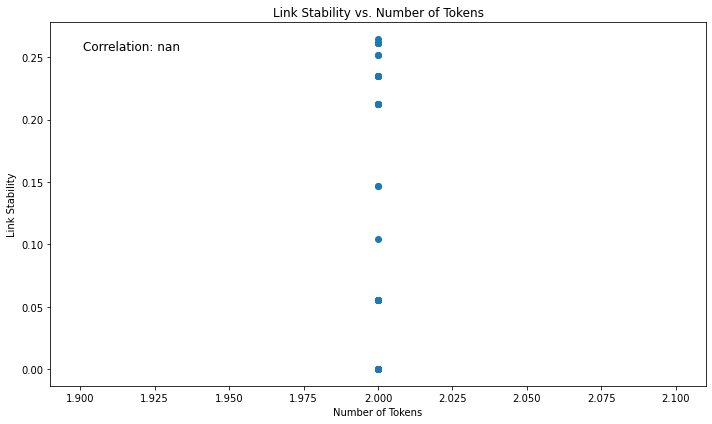

In [129]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import ast
from scipy.stats import pearsonr



def plot_link_stability_vs_no_of_tokens(metric_dataframes, output_path="output/links/", save=True, show=True):
    # Constants for aesthetics
    FIG_SIZE = (10, 6)

    # Extract data
    df = metric_dataframes['sample']['size_link']

    # Calculate the mean size and stability (variance) for each clique
    no_of_tokens = np.array(([len(ast.literal_eval(clique)) for clique in df.index]))
    
    stability = np.array(df.notna().astype(int).var(axis=1)) # note binary measure of stability

    # Prepare figure and axis for plotting
    fig, ax = plt.subplots(figsize=FIG_SIZE)

    # Create a scatter plot of stability versus mean size
    ax.scatter(no_of_tokens, stability)
    
    # Labels and Title
    ax.set_xlabel("Number of Tokens")
    ax.set_ylabel("Link Stability")
    ax.set_title("Link Stability vs. Number of Tokens")

    # Show the correlation value on the plot
    correlation, p_value = pearsonr(no_of_tokens, stability)
    
    print("Pearson correlation coefficient:", correlation)
    print("p-value:", p_value)
    
    ax.text(0.05, 0.95, f'Correlation: {correlation:.2f}', transform=ax.transAxes,
            fontsize=12, verticalalignment='top')

    plt.tight_layout()

    # Save or show the figure
    if save:
        plt.savefig(f"{output_path}/link_stability_vs_size.png", bbox_inches='tight')
    if show:
        plt.show()

# Assuming metric_dataframes is already defined somewhere in your code
plot_link_stability_vs_no_of_tokens(metric_dataframes, output_path="output/links/", save=False, show=True)


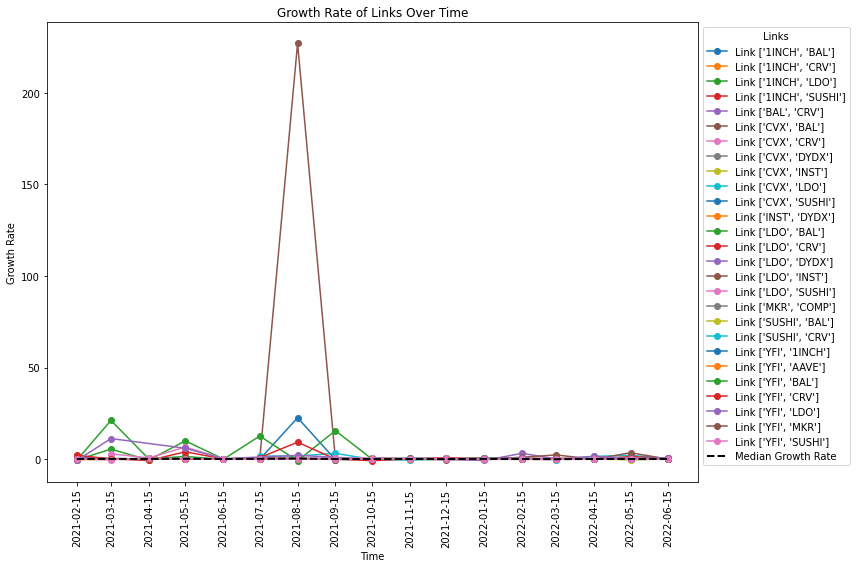

In [134]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def plot_link_growth_rate_over_time(metric_dataframes, output_path="output/links/", save=True, show=True):
    # Constants for aesthetics
    FIG_SIZE = (12, 8)
    MEDIAN_LINE_STYLE = {'color': 'black', 'linewidth': 2, 'linestyle': '--', 'label': 'Median Growth Rate'}

    # Extract data
    df = metric_dataframes['sample']['internal_influence']

    # Ensure columns are datetime objects and sort them
    df.columns = pd.to_datetime(df.columns)
    df = df.sort_index(axis=1)

    # Prepare a DataFrame to store growth rates
    growth_rate_df = pd.DataFrame(index=df.index, columns=df.columns)

    # Calculate growth rates for each link based on available values
    for link, values in df.iterrows():
        available_values = values.dropna()
        if len(available_values) > 1:
            growth_rates = available_values.pct_change().dropna()
            growth_rate_df.loc[link, growth_rates.index] = growth_rates

    # Filter links that occur less than 4 times
    valid_links = growth_rate_df.dropna(thresh=4).index
    filtered_growth_rate_df = growth_rate_df.loc[valid_links]

    # Calculate median growth rates over time
    median_growth_rate = filtered_growth_rate_df.median(axis=0).dropna()

    # Prepare figure and axis
    fig, ax = plt.subplots(figsize=FIG_SIZE)

    # Plot available growth rates for each link
    for link in valid_links:
        link_growth_rates = filtered_growth_rate_df.loc[link].dropna()
        ax.plot(link_growth_rates.index, link_growth_rates, marker='o', linestyle='-', label=f'Link {link}')

    # Plot median growth rate over time
    ax.plot(median_growth_rate.index, median_growth_rate, **MEDIAN_LINE_STYLE)

    # Labels and Title
    ax.set_xlabel("Time")
    ax.set_ylabel("Growth Rate")
    ax.set_title("Growth Rate of Links Over Time")

    # Set tick positions and labels
    ax.set_xticks(median_growth_rate.index)  # Set tick positions
    ax.set_xticklabels(median_growth_rate.index.strftime('%Y-%m-%d'), rotation=90)  # Set tick labels and rotate for better readability

    # Add legend
    ax.legend(title="Links", loc='upper left', bbox_to_anchor=(1, 1))

    plt.tight_layout()

    if save:
        plt.savefig(f"{output_path}/growth_rate_over_time.png", bbox_inches='tight')

    if show:
        plt.show()

# Assuming metric_dataframes is already defined somewhere in your code
plot_link_growth_rate_over_time(metric_dataframes, output_path="output/links/", save=False, show=True)


### Fig: clique_size vs total_influence 

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from os.path import join

def plot_clique_size_influence_correlation(metric_dataframes, method='upper_bound', group='sample', output_path="output/cliques/", save=True, show=True):
    # Define dfs
    df_size = metric_dataframes[method][group]['size_clique']
    df_influence = metric_dataframes[method][group]['total_influence']

    # Calculate correlations for each timestamp
    correlations = df_size.corrwith(df_influence, axis=0)

    # Plotting the correlations
    plt.figure(figsize=(10, 5))
    plt.plot(correlations.index, correlations, marker='o', linestyle='-')
    plt.xlabel('Timestamps', fontsize=12)
    plt.ylabel('Correlation between Clique Size and Total Influence', fontsize=12)
    plt.title(f'[{method.upper()}]: Correlation of Clique Size and Total Influence Over Time', fontsize=14)
    plt.grid(True)

    plt.xticks(rotation=90)  # Rotate x-tick labels by 90 degrees

    # Save the plot to the specified output path
    if save:
        plt.savefig(join(output_path, f'clique_size_influence_correlation_{method}_{group}.png'))

    if show:
        plt.show()
    else:
        plt.close()

# Example usage
plot_clique_size_influence_correlation(metric_dataframes, method='upper_bound', group='sample', save=False, show=True)


### Fig: total_influence

In [81]:
FONT_SIZE_TEXT = 16
FONT_SIZE_LABEL = 20
FONT_SIZE_TITLE = 24
FONT_SIZE_VALUE = 12
FIG_SIZE = (25, 20)

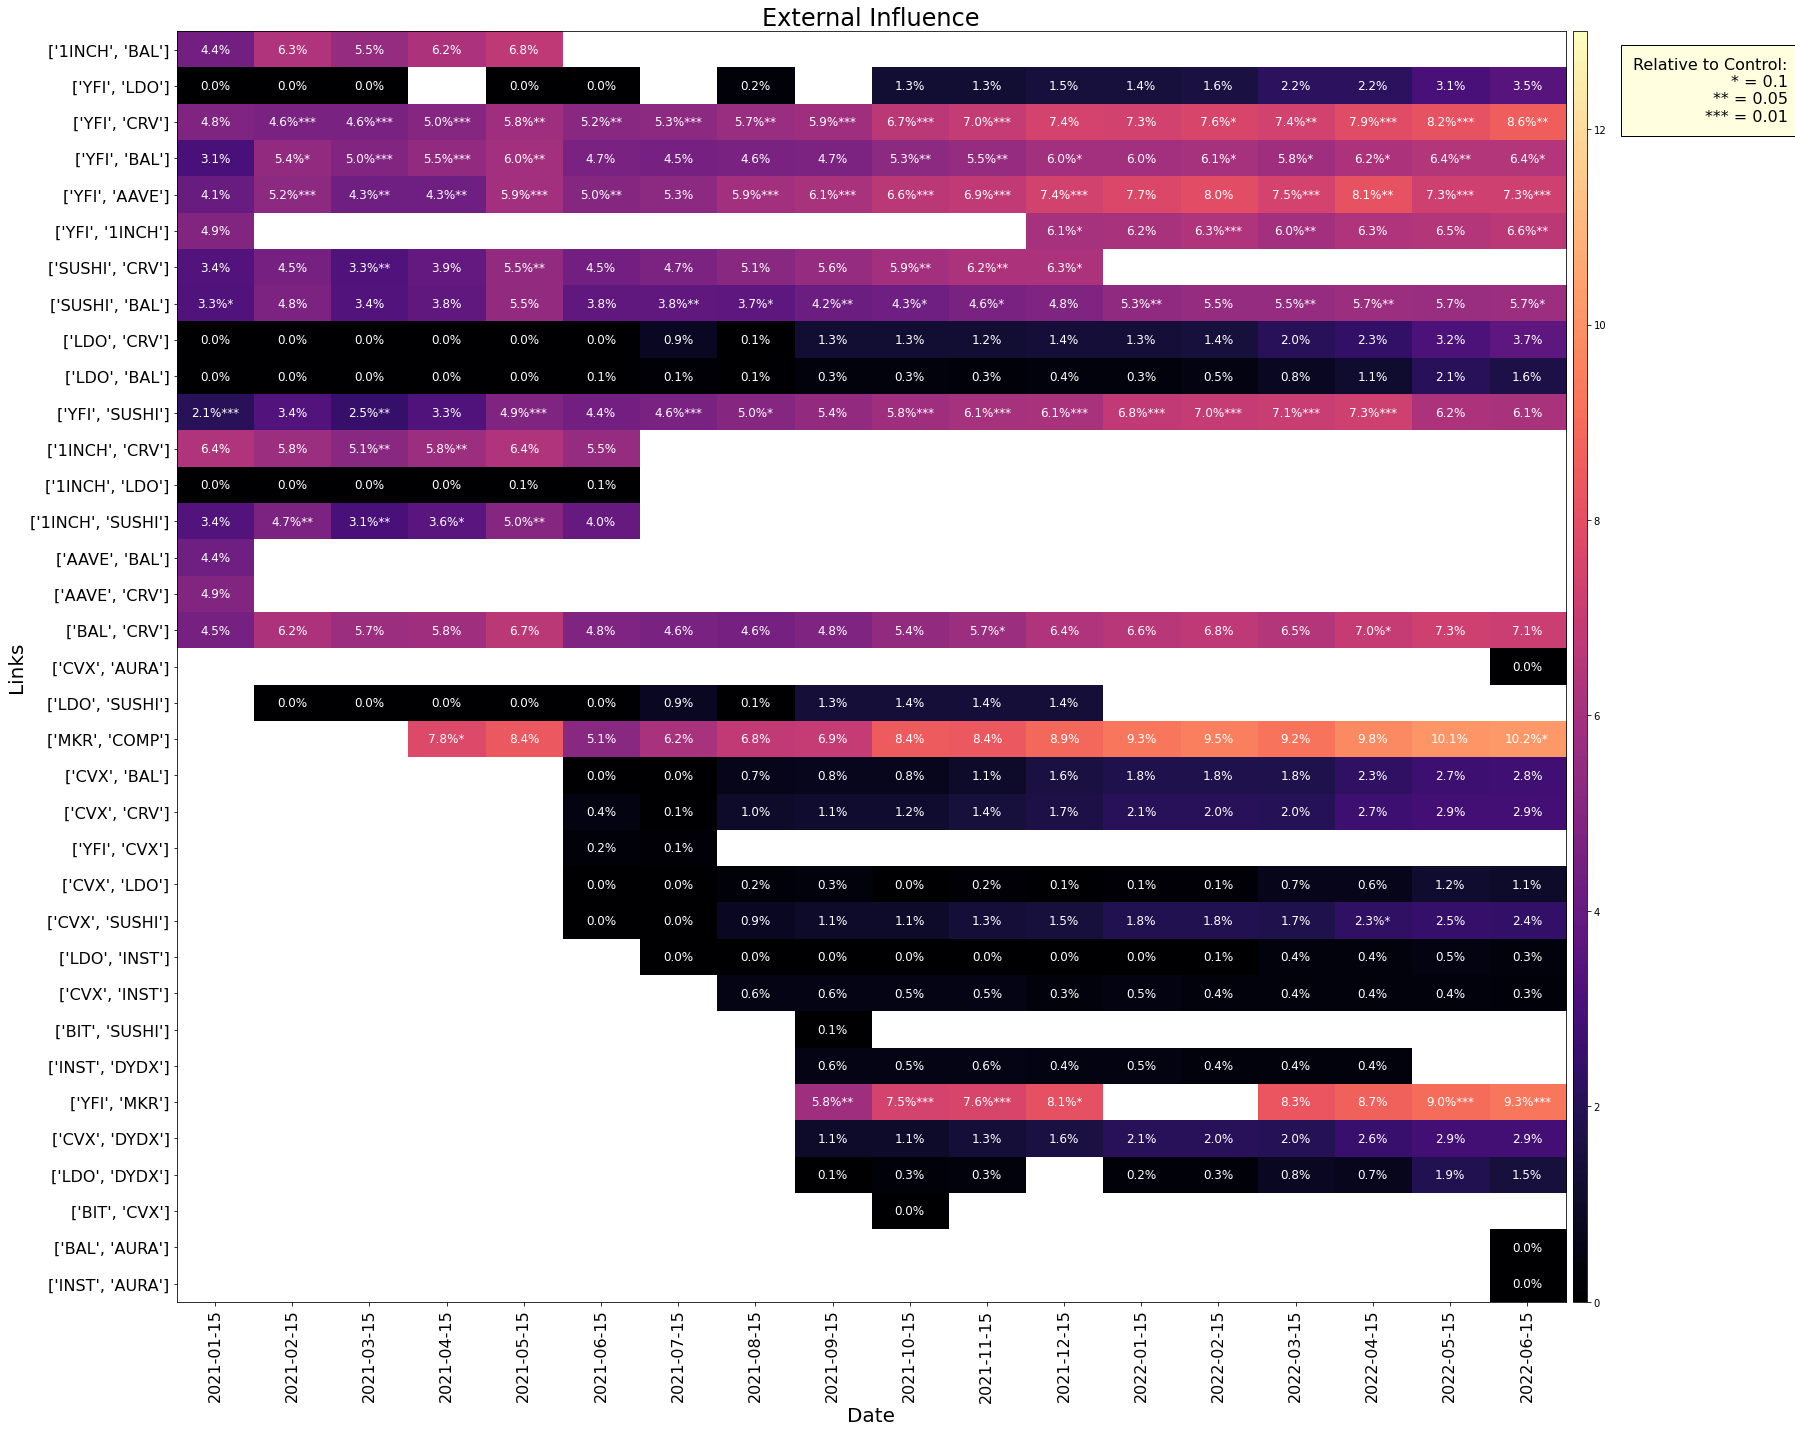

In [122]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from os.path import join
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.cm import ScalarMappable

def plot_heatmap_chart(metric_dataframes, metric_name, pct=True, output_path="../output/links/", save=False, show=True):
    
    if pct==True: 
        multiplier = 100 
        unit='%'
    else: 
        multiplier = 1
        unit=''

    # Define df
    df = metric_dataframes['sample'][metric_name] * multiplier
    df_pv = metric_dataframes['pvalues'][metric_name]
    
    # reindex
    df_index = metric_dataframes['sample'][metric_name] * multiplier

    # Find the index of the first occurrence (value > 1) in each column (snapshot)
    first_occurrence_indices = (df_index.T > 0).idxmax()
    
    # Determine the minimum index (earliest occurrence) for each clique across all snapshots
    min_indices = first_occurrence_indices.groupby(first_occurrence_indices.index).min()
    
    # Sort the cliques based on their minimum indices to get the desired order
    cliques_order = min_indices.sort_values().index.tolist()

    # Reindex clique size to df
    df= df.reindex(cliques_order)
    df_pv = df_pv.reindex(cliques_order)

    fig, ax = plt.subplots(figsize=FIG_SIZE)

    # Create colormap
    cmap = plt.get_cmap("magma", lut=128)
    norm = mcolors.Normalize(vmin=0, vmax=round(df.max().max()*1.3))

    # Plotting the values
    im = ax.imshow(df, cmap=cmap, norm=norm, aspect='auto', interpolation='none')


    # Colorbar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="1%", pad=0.1)  # '2%' determines the width of the colorbar
    cbar = plt.colorbar(ScalarMappable(norm=norm, cmap=cmap), cax=cax, orientation='vertical')
    tick_vals = np.array(cbar.get_ticks()) 
    # cbar.set_ticklabels([f'{round(val)}%' for val in tick_vals])
    
    # Significance box
    plt.text(1.16, 0.98, 'Relative to Control:\n* = 0.1\n** = 0.05\n*** = 0.01', 
         transform=ax.transAxes, fontsize=FONT_SIZE_TEXT, 
         verticalalignment='top', horizontalalignment='right',
         bbox=dict(facecolor='lightyellow', alpha=1, pad=12))
    # Labels and title
    ax.set_xlabel('Date', size=FONT_SIZE_LABEL)
    ax.set_ylabel('Links', size=FONT_SIZE_LABEL)
    ax.set_title(f'{metric_name.replace("_", " ").title()}', size=FONT_SIZE_TITLE)
    ax.set_xticks(np.arange(len(df.columns)))
    ax.set_xticklabels(df.columns, rotation=90, ha='center', size=FONT_SIZE_TEXT)
    ax.set_yticks(np.arange(len(df.index)))
    ax.set_yticklabels(df.index, size=FONT_SIZE_TEXT)
    plt.grid(False)
    plt.tight_layout()


    # Annotate the values on the plot
    for i in range(len(df.index)):
        for j in range(len(df.columns)):
            value = df.values[i, j]
            pval = df_pv.values[i, j]
            pval = pval_to_significance(pval) 
            if not np.isnan(value):
                text = ax.text(j, i, f'{value:.1f}{unit}{pval}', ha='center', va='center', color='white', fontsize=FONT_SIZE_VALUE)

    # Save and/or show the plot
    if save:
        plt.savefig(join(output_path, f'{metric_name}_links.png'), bbox_inches='tight')
    if show:
        plt.show()

# Assuming metric_dataframes is already defined somewhere in your code
plot_heatmap_chart(metric_dataframes, metric_name='external_influence', pct=True, save=True, show=True)


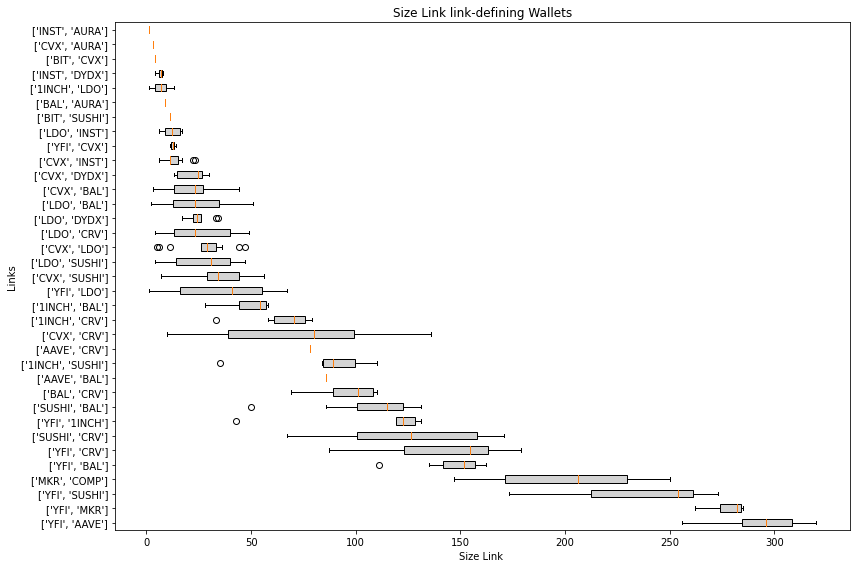

In [125]:
from matplotlib.cm import ScalarMappable
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
import pandas as pd
import numpy as np

# ['size_clique', 'total_influence', 'gini_total_influence', 'internal_influence', 'gini_internal_influence', 'external_influence', 'gini_external_influence', 'wealth_clique', 'gini_wealth_clique', 'median_wealth_level_clique', 'median_no_assets_clique', 'max_influence_label', 'max_influence_label_distribution']

def plot_boxplot_with_significance(metric_dataframes, metric, unit, output_path="output/cliques/", save=True, show=True):
    # Constants for aesthetics
    FIG_SIZE = (12, 8)
    COLOR_MAP = {'non-significant': 'lightgray', '0.05': 'yellow', '0.01': 'orange', '0.001': 'red'}

    # Extract data
    df = metric_dataframes['sample'][metric]
    
    # load p_values to control
    df_pvalues = metric_dataframes['pvalues'][metric]

    # Sort cliques by average influence
    cliques_order = df.mean(axis=1).sort_values(ascending=False).index
    df = df.reindex(cliques_order)
    df_pvalues = df_pvalues.reindex(cliques_order)

    # Prepare figure and axis
    fig, ax = plt.subplots(figsize=FIG_SIZE)

    # Create boxplot data
    boxplot_data = [df.loc[clique].dropna() for clique in cliques_order]
    boxplot = ax.boxplot(boxplot_data, vert=False, patch_artist=True)

    # Color and annotate based on significance
    for i, clique in enumerate(cliques_order):
        p_values = df_pvalues.loc[clique].dropna()
        # Determine the most common significance level based on mode
        try: 
            significance = p_values.apply(lambda x: '0.001' if x < 0.001 else ('0.01' if x < 0.01 else ('0.05' if x < 0.05 else 'non-significant'))).mode()[0]
        except: 
            significance = 'non-significant'
        boxplot['boxes'][i].set_facecolor(COLOR_MAP[significance])

    # Adding legend for significance
    if metric == 'size_link':
        
        pass
        
    else:
        legend_patches = [mpatches.Patch(color=color, label=significance) for significance, color in COLOR_MAP.items()]
        ax.legend(handles=legend_patches, title="Significance Levels", loc='upper left', bbox_to_anchor=(1, 1))

    # Labels and Title
    metric_name_formatted = ' '.join(metric.split('_')).title()
    
    ax.set_yticks(np.arange(1, len(cliques_order) + 1))
    ax.set_yticklabels(cliques_order)
    ax.set_ylabel('Links')
        
    ax.set_xlabel(f"{metric_name_formatted} {unit}")
 
    ax.set_title(f"{metric_name_formatted} link-defining Wallets")
    
        

    plt.tight_layout()

    if save:
        plt.savefig(f"{output_path}/{metric}_significance_boxplot.png", bbox_inches='tight')

    if show:
        plt.show()

# Assuming metric_dataframes is already defined somewhere in your code
plot_boxplot_with_significance(metric_dataframes, 'size_link', unit='', output_path="../output/links/", save=True, show=True)

### Growth Rates 

In [ ]:
df = pd.DataFrame(metric_dataframes['lower_bound']['sample']['total_influence'])

# Function to calculate growth rates
def calculate_growth_rates(series):
    valid_dates = series.dropna().index
    rates = []
    dates = []
    for i in range(len(valid_dates) - 1):
        value_prev = series[valid_dates[i]]
        value_next = series[valid_dates[i+1]]
        growth = (value_next - value_prev) / value_prev * 100
        rates.append(growth)
        dates.append(valid_dates[i+1])
    return pd.Series(data=rates, index=dates)

# Apply function and prepare data for plotting
growth_df = df.apply(calculate_growth_rates)

# Plotting
plt.figure(figsize=(12, 8))
for index, row in growth_df.iterrows():
    if not row.empty:
        plt.plot(row.index, row, marker='o', label=index)

plt.title('Growth Rates Over Time for Each Clique')
plt.xlabel('Date')
plt.ylabel('Growth Rate (%)')
plt.legend(title='Clique Name')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
(df.mean(axis=0).diff(1)/df.sum(axis=0))*100

### Fig: Distribution of Labels

In [104]:
df = metric_dataframes['sample']['max_influence_label_distribution'].copy()
df.reset_index(inplace=True)

In [105]:
import pandas as pd
import numpy as np
import ast

def create_matrix_from_dataframe(original_dataframe):
    # Create a copy of the dataframe to avoid modifying the original
    dataframe = original_dataframe.copy()
    
    # Function to convert string dictionary to actual dictionary
    def convert_str_to_dict(x):
        try:
            if isinstance(x, str):
                return ast.literal_eval(x)
            elif isinstance(x, dict):
                return x
            else:
                return {}
        except:
            return {}

    # Apply the conversion function to each relevant column of the dataframe
    for column in dataframe.columns[1:]:  # Skipping the 'Clique Name' column
        dataframe[column] = dataframe[column].apply(convert_str_to_dict)

    # Function to extract and average values for each contract type
    def extract_and_average(data_row):
        contract_sums = {}
        contract_counts = {}
        for cell in data_row:
            for contract_type, value in cell.items():
                if contract_type in contract_sums:
                    contract_sums[contract_type] += value
                    contract_counts[contract_type] += 1
                else:
                    contract_sums[contract_type] = value
                    contract_counts[contract_type] = 1
        # Calculate averages, ensuring to divide only by the number of non-empty entries
        averages = {contract: contract_sums[contract] / contract_counts[contract]
                    for contract in contract_sums if contract_counts[contract] > 0}
        return averages

    # Applying the function to each row of the dataframe (ignoring the first column which is 'Clique Name')
    dataframe['averages'] = dataframe[dataframe.columns[1:]].apply(extract_and_average, axis=1)

    # Create a new dataframe to hold the matrix
    matrix_df = pd.DataFrame(index=dataframe['Link Name'])

    # Populate the matrix with average values
    for index, row in dataframe.iterrows():
        for contract_type, avg_value in row['averages'].items():
            matrix_df.at[row['Link Name'], contract_type] = avg_value

    # Fill NaN values with 0 indicating no interactions were recorded
    matrix_df.fillna(0, inplace=True)

    return matrix_df

# Example of how to use this function:
matrix_df = create_matrix_from_dataframe(df)


In [106]:
# Handling NaN values by filling them with 0 (or another appropriate value)
matrix_df = matrix_df.fillna(0)

# Computing the sum of each row, handling rows that sum to zero
row_sums = matrix_df.sum(axis=1).replace(0, np.nan)  # Replace 0 with NaN to avoid division by zero

# Performing the division safely
result_df = matrix_df.div(row_sums, axis=0)

In [107]:
# Mapping to shorter human-readable labels
short_readable_labels = {
    'EMOA': 'Retail Wallets',
    'IEMOA': 'Institutional Wallets',  # Corrected "Instituinal" to "Institutional"
    'PCV': 'Protocol Wallets',
    'bridge_contract': 'Bridge Contracts',
    'other_contracts': 'Other Contracts',
    'vesting_contract': 'Vesting Contracts',
    'external_staking_contracts': 'Staking Contracts',
    'lp_amm': 'Liquidity Pools',
    'lending_borrowing_contract': 'Lending/Borrowing'
}


result_df.rename(columns=short_readable_labels, inplace =True)



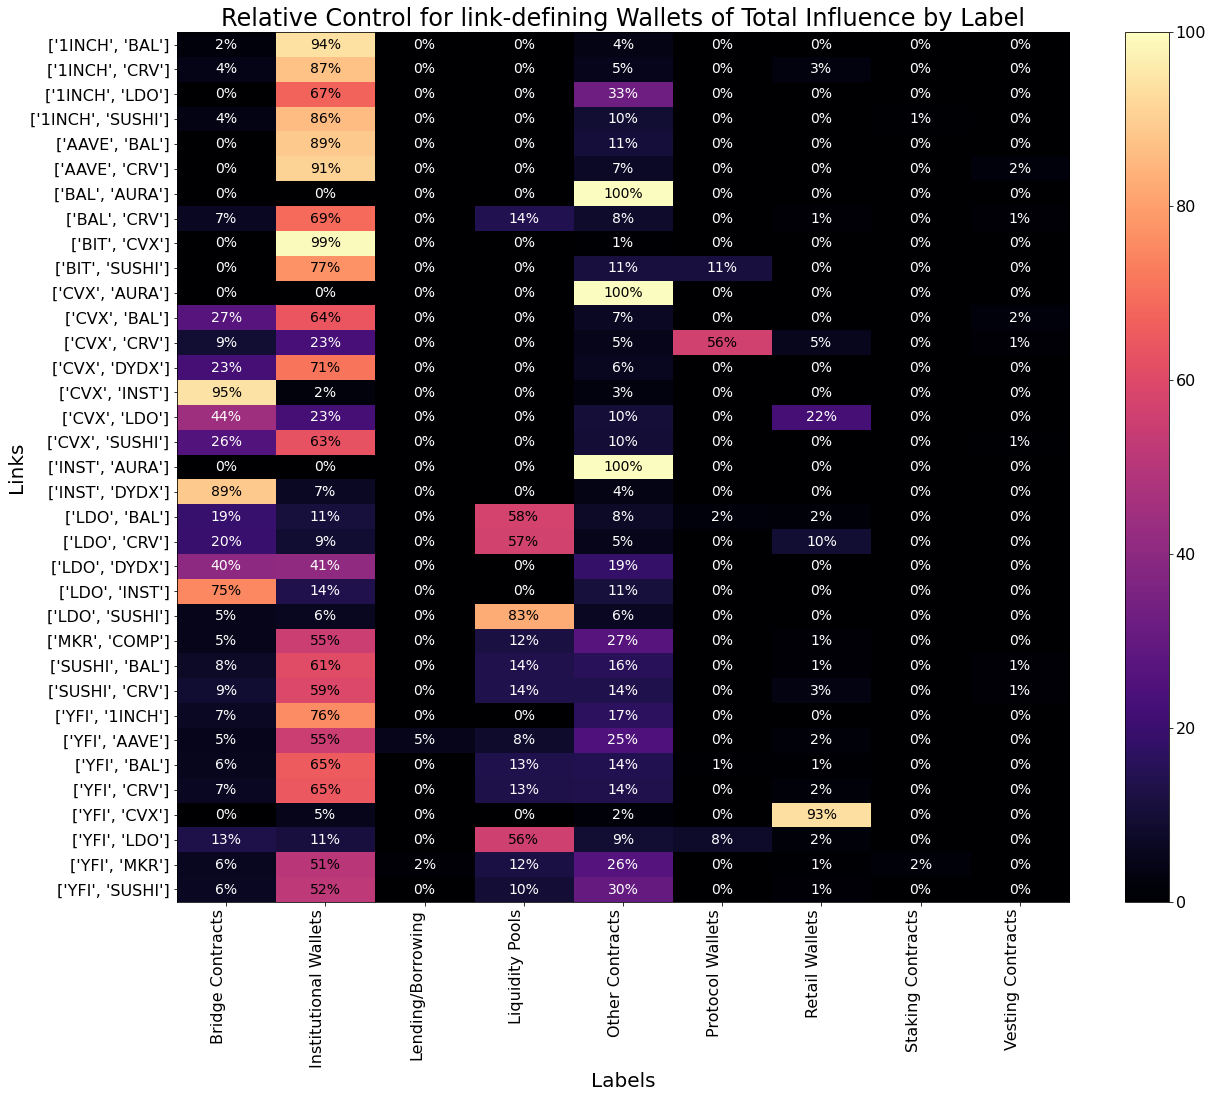

In [111]:
import matplotlib.pyplot as plt
import numpy as np

def plot_heatmap(df):
    
    fig, ax = plt.subplots(figsize=(20,16))  # Use global figure size
    
    df = df.sort_index(axis=1)


    # Data preparation: Convert DataFrame values to percentages
    data = df.to_numpy() * 100  # Convert to numpy array for matplotlib and scale to percent

    # Create the heatmap
    cax = ax.matshow(data, cmap='magma', aspect='auto')  # Adjusted aspect ratio

    # Adding a color bar, adjusting fraction and pad for a slimmer look
    color_bar = fig.colorbar(cax, ax=ax)
    color_bar.ax.tick_params(labelsize=FONT_SIZE_TEXT)  # Set font size for color bar ticks

    

    # Setting axis labels
    ax.set_xlabel('Labels', fontsize=FONT_SIZE_LABEL)
    ax.set_ylabel('Links', fontsize=FONT_SIZE_LABEL)


    # Setting title
    ax.set_title('Relative Control for link-defining Wallets of Total Influence by Label', fontsize=FONT_SIZE_TITLE)

    # Setting tick marks based on DataFrame columns and index
    ax.set_xticks(np.arange(len(df.columns)))
    ax.set_xticklabels(df.columns, rotation=90, ha='right', size=16)
    ax.xaxis.set_ticks_position('bottom')  # Ensuring ticks are only on the bottom
    ax.set_yticks(np.arange(len(df.index)))
    ax.set_yticklabels(df.index, size=16)
    
    # Move x-axis labels to the bottom
    ax.tick_params(axis='x', bottom=True, top=False, labelbottom=True)

    # Adding text annotations inside the heatmap
    text_color_threshold = np.max(data) / 2  # Adjust color threshold based on data max
    for (i, j), val in np.ndenumerate(data):
        ax.text(j, i, f'{val:.0f}%', ha='center', va='center',
                color='white' if val < text_color_threshold else 'black',
                fontsize=14)  # Adjusted text size for better fit
        
    output_path = '../output/links'
    plt.savefig(f"{output_path}/label_plot_links.png", bbox_inches='tight')


    plt.show()

# Call the function with the matrix dataframe
plot_heatmap(result_df)
